In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt

In [3]:
#add years on x axis for predicted v real close prices (& HAR)
#remove 0 values for summary table

# Data collection

In [6]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2016-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

# Descriptive statistics

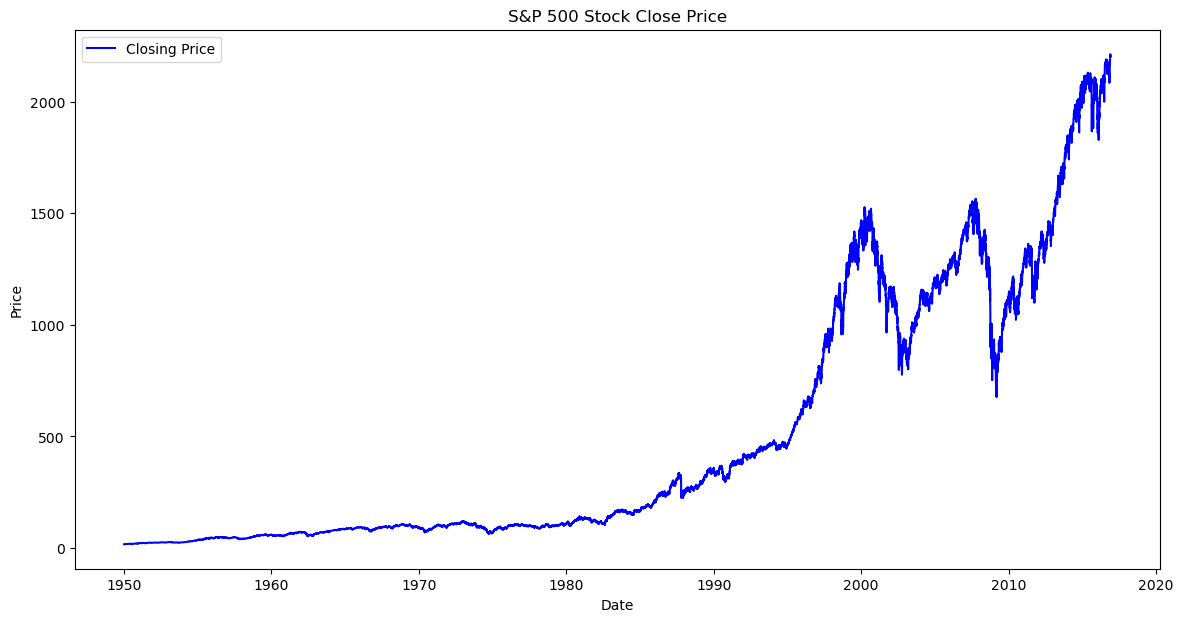

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(daily.index, daily['Close'], label='Closing Price', color='blue')
plt.title('S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
clean_daily = yf.download(ticker, start="1950-03-01", end="2016-01-11", interval="1d")
clean_daily.loc[(clean_daily['Open'] == 0), 'Open'] = np.nan
clean = clean_daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
clean = clean.dropna()

descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [clean['Open'].min(), clean['High'].min(), clean['Low'].min(), clean['Close'].min()],
    "Max": [clean['Open'].max(), clean['High'].max(), clean['Low'].max(), clean['Close'].max()],
    "Mean": [clean['Open'].mean(), clean['High'].mean(), clean['Low'].mean(), clean['Close'].mean()],
    "Std.": [clean['Open'].std(), clean['High'].std(), clean['Low'].std(), clean['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('summary_table.csv', index=False, sep=';')
summary_table

[*********************100%%**********************]  1 of 1 completed


,Price,Min,Max,Mean,Std.
0,Open,17.24,2108.64,650.35,592.87
1,High,17.56,2134.72,671.77,610.49
2,Low,16.68,2067.93,628.02,572.92
3,Close,17.29,2107.39,653.59,594.67


# Model Selection

In [16]:
#Method 1 : visual choice
sample = monthly[561:801] #1996-12-01 to 2016-01-01
sample = sample[sample.columns[1:5]]
monthly = monthly[monthly.columns[1:5]]

# Set the number of observations to consider for each iteration
T = 120

AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(42)
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=T)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=T)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(sample[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(sample[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

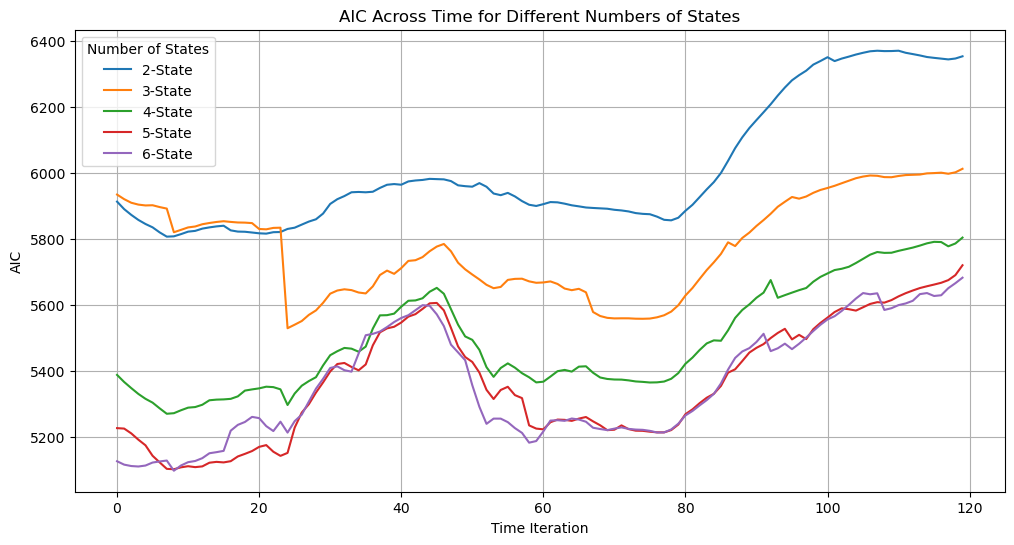

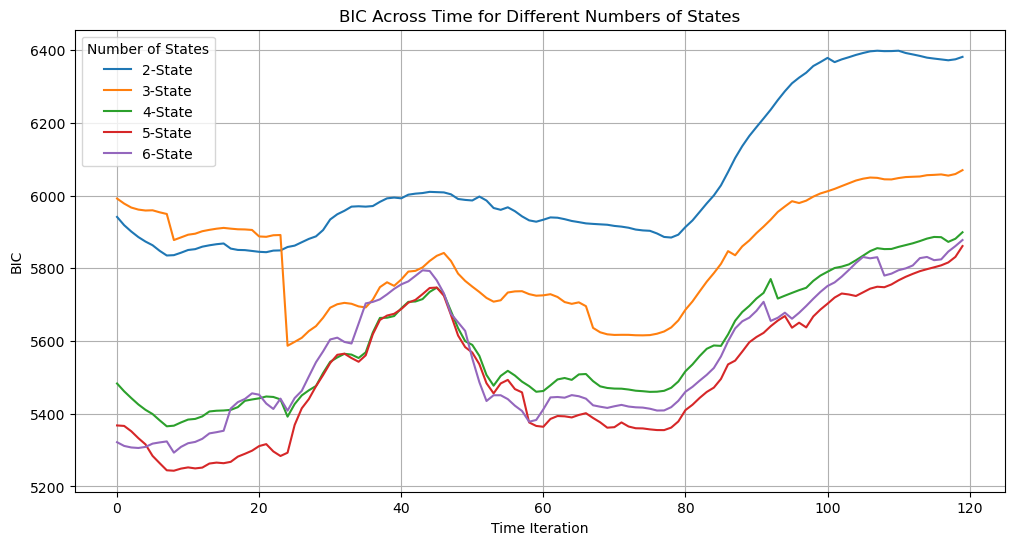

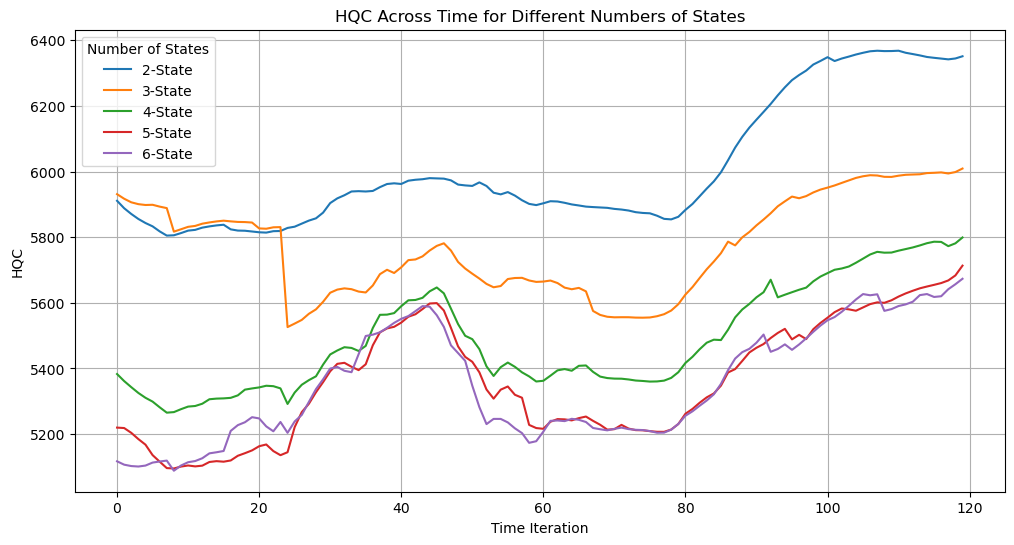

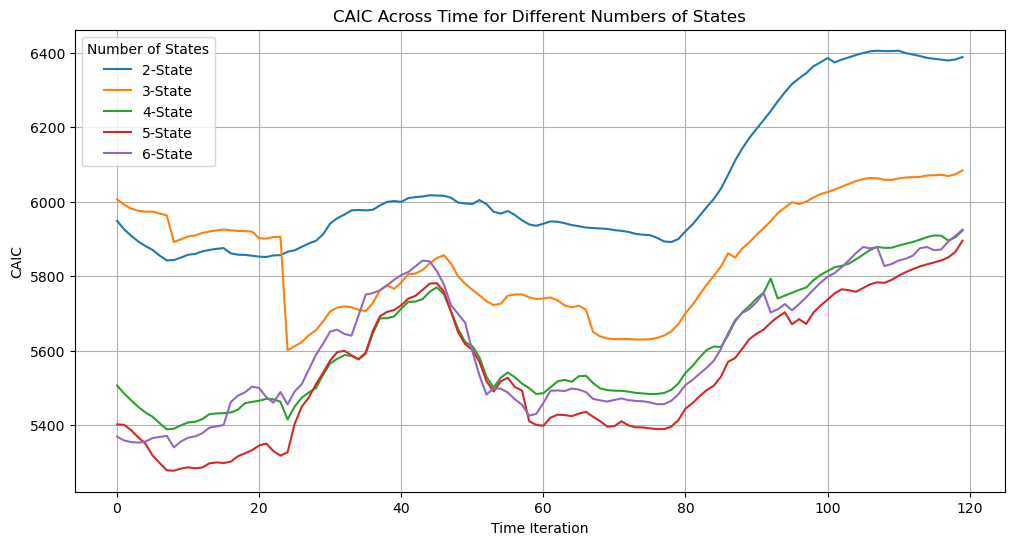

In [17]:
#Plot AIC values for different numbers of components
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("AIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

#Plot BIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("BIC_plot.png", format='png', dpi=300)  
plt.show()

#Plot HQC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("HQC_plot.png", format='png', dpi=300) 
plt.show()

#Plot CAIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("CAIC_plot.png", format='png', dpi=300)  
plt.show()

In [18]:
#Method 2 : algoritmic choice 
#we are using the same obs as before
state_range = range(2, 7) 
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(sample)
T=120

def calculate_model_criteria(hmm_model, M, k):                  #M as number of observations, k as number of parameters 
    L = hmm_model.score(sample)                                    #Use the correct model passed as the argument
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=42)
    model.fit(sample)

    # Number of parameters: Transition, emission, and initial probabilities
    num_params = num_states ** 2 + 2 * num_states - 1
    
    # Calculate evaluation criteria
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    # Update best model based on BIC as the primary criterion
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

Best Model Criteria: {'AIC': 11321.09128916375, 'BIC': 11484.681318560824, 'HQC': 11387.0061276491, 'CAIC': 11531.681318560824}
47
6


# Prediction using HMM

In [23]:
# Calculate number of rows and set training window
T = 682  # Set the starting point for training data (from row 1 to row 682)

# Define the size of the training window
d = 120
D = 120
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = monthly.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(42)

    if(first_time):
        first_time = False
        model = hmm.GaussianHMM(n_components=5)
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=5, init_params="c")
        model.startprob_ = old_model.startprob_
        model.transmat_ = old_model.transmat_
        model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t = T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t - D > 0:
        t = t - 1

        train_data = monthly.iloc[t - D:t]
        new_likelihood = model.score(train_data)
        if abs(new_likelihood - original_likelihood) < min_diff:  # Threshold for comparison
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = monthly['Close'][T - 1] + ((monthly['Close'][min_t + 1] - monthly['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T = T + 1

# Plot the predicted and observed prices from rows 682 to 802
close = []
truncated_obs = monthly.iloc[682:802]

for i in truncated_obs['Close']:
    close.append(i)

T =  682


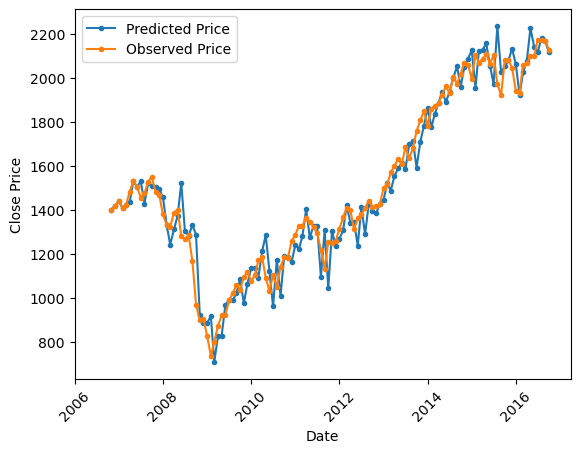

In [24]:
dates = monthly_with_dates.index[682:802]

# Plot the data
plt.plot(dates, hmm_price, marker='.', label="Predicted Price")
plt.plot(dates, close, marker='.', label="Observed Price")
plt.xlabel("Date")
plt.ylabel("Close Price")


years = dates.year.unique()
ticks = [year for year in years if year % 2 == 0]  # Show ticks every 5 years

# Set x-ticks to those years
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in ticks]))
plt.gca().set_xticklabels([f"{year}" for year in ticks])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add the legend and display the plot
plt.legend()
plt.show()

# Performance Evaluation

In [34]:
# do R2, RMSE, and confusion matrix?

In [36]:
# HMM vs HAR Returns (Out_of_sample R^2 based on stock Returns) R^2_OSR
m = d // 2

# Calculating the monthly return of closing price
close_return = [(close[i] - close[i-1]) / close[i-1] if i> 0 else 0 for i in range(d)]

#The real stock returns at each time step.
real_return=[(close[i] - close[i-1]) / close[i-1] for i in range(m+1, d)]

#The relative stock return based on the HMM model.
pred_return = [(hmm_price[i]-close[i-1])/close[i-1] for i in range(m+1,d)]

#The predicted stock returns based on the historical average return method.
har_return = [np.mean(close_return[:i]) for i in range(m+1,d)]
# har_return = [(np.mean(close[:i]) - close[i-1])/close[i-1] for i in range(m+1,D)]

# Calculate the squared errors between real return and predicted returns
squared_error_hmm_r = np.square( np.array(real_return) - np.array(pred_return))
squared_error_har_r = np.square(np.array(real_return) - np.array(har_return))

# Calculate the out-of-sample R2 for stock return based on predicted retur (R2_OSR)
r2_osr = 1 - np.sum(squared_error_hmm_r)/np.sum(squared_error_har_r)

print(r2_osr, 1 - np.sum(squared_error_hmm_r), 1 - np.sum(squared_error_har_r))


-0.8012913945955533 0.8317484797058645 0.9065939465436056


In [38]:
# HMM vs HAR Price (Out_of_sample R^2 based on stock Price) R^2_OSP
m = D // 2

#The real stock prices at each time step.
real_price=[close[i] for i in range(m+1,D)]

#The predicted stock prices based on the HMM model.
pred_price = [hmm_price[i] for i in range(m+1,D)]

#The predicted stock prices based on the historical average return method.
har_return_new = [np.mean(close_return[:i]) if i > 0 else 0 for i in range(D)]
har_price = [close[i-1]*(har_return_new[i]+1) for i in range(m+1,D)]

# Calculate the squared errors between real price and predicted price
squared_error_hmm = np.square(np.array(real_price) - np.array(pred_price))
squared_error_har = np.square(np.array(real_price) - np.array(har_price))

# Calculate the out-of-sample R2 for stock price based on predicted price (R2_OSP)
r2_osp = 1 - np.sum(squared_error_hmm)/np.sum(squared_error_har)

print(r2_osp)

-0.7996016089014941


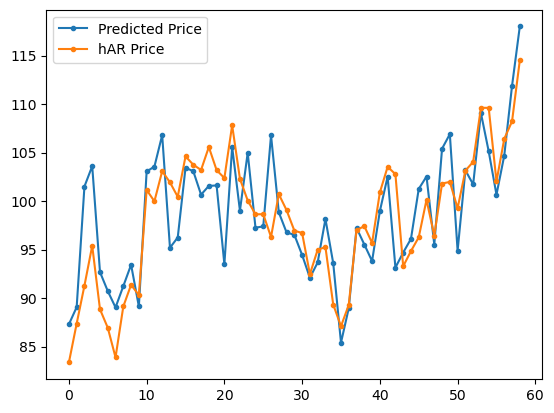

In [40]:
plt.plot(pred_price,marker='.', label = "Predicted Price")
# plt.plot(real_price,marker = '.', label= "Observed Price")
plt.plot(har_price,marker = '.', label= "hAR Price")
plt.legend()
plt.show()

In [112]:
# RMSE Error Estimate
N = m-2
def rmse(real_, pred_):
  sum = 0
  for i in range(1,N):
    sum += (np.square(real_[i] - pred_[i]))
  RMSE = np.sqrt(sum/N)
  return RMSE

rmse_hmm_price = rmse(real_price, pred_price)
rmse_har_price = rmse(real_price, har_price)
rmse_hmm_return = rmse(real_return, pred_return)
rmse_har_return = rmse(real_return, har_return)
rmse_eff_price = 1 - rmse_hmm_price/rmse_har_price
rmse_eff_return = 1 - rmse_hmm_return/rmse_har_return
print("rmse_hmm_price=",rmse_hmm_price) 
print("rmse_har_price=",rmse_har_price) 
print("rmse_eff_price=",rmse_eff_price)
print("rmse_hmm_return=",rmse_hmm_return)
print("rmse_har_return=", rmse_har_return)
print("rmse_eff_return=",rmse_eff_return)

rmse_hmm_price= 5.167768860145423
rmse_har_price= 3.839506353349251
rmse_eff_price= -0.34594616717784876
rmse_hmm_return= 0.05362699638183442
rmse_har_return= 0.03963693189708305
rmse_eff_return= -0.35295528223719375


In [ ]:
# Step 8: Trading simulation (buy if predicted rise, sell otherwise) uhhhh
data['Signal'] = np.where(data['Predicted'] > obs, 1, -1)
data['Return'] = data['Signal'] * obs.pct_change()

hmm_cumulative_return = (1 + data['Return']).cumprod()
buy_and_hold_return = (1 + obs.pct_change()).cumprod()

# Print results
print(f"HMM Cumulative Return: {hmm_cumulative_return.iloc[-1]:.2f}")
print(f"Buy-and-Hold Cumulative Return: {buy_and_hold_return.iloc[-1]:.2f}")

## failed tries idk